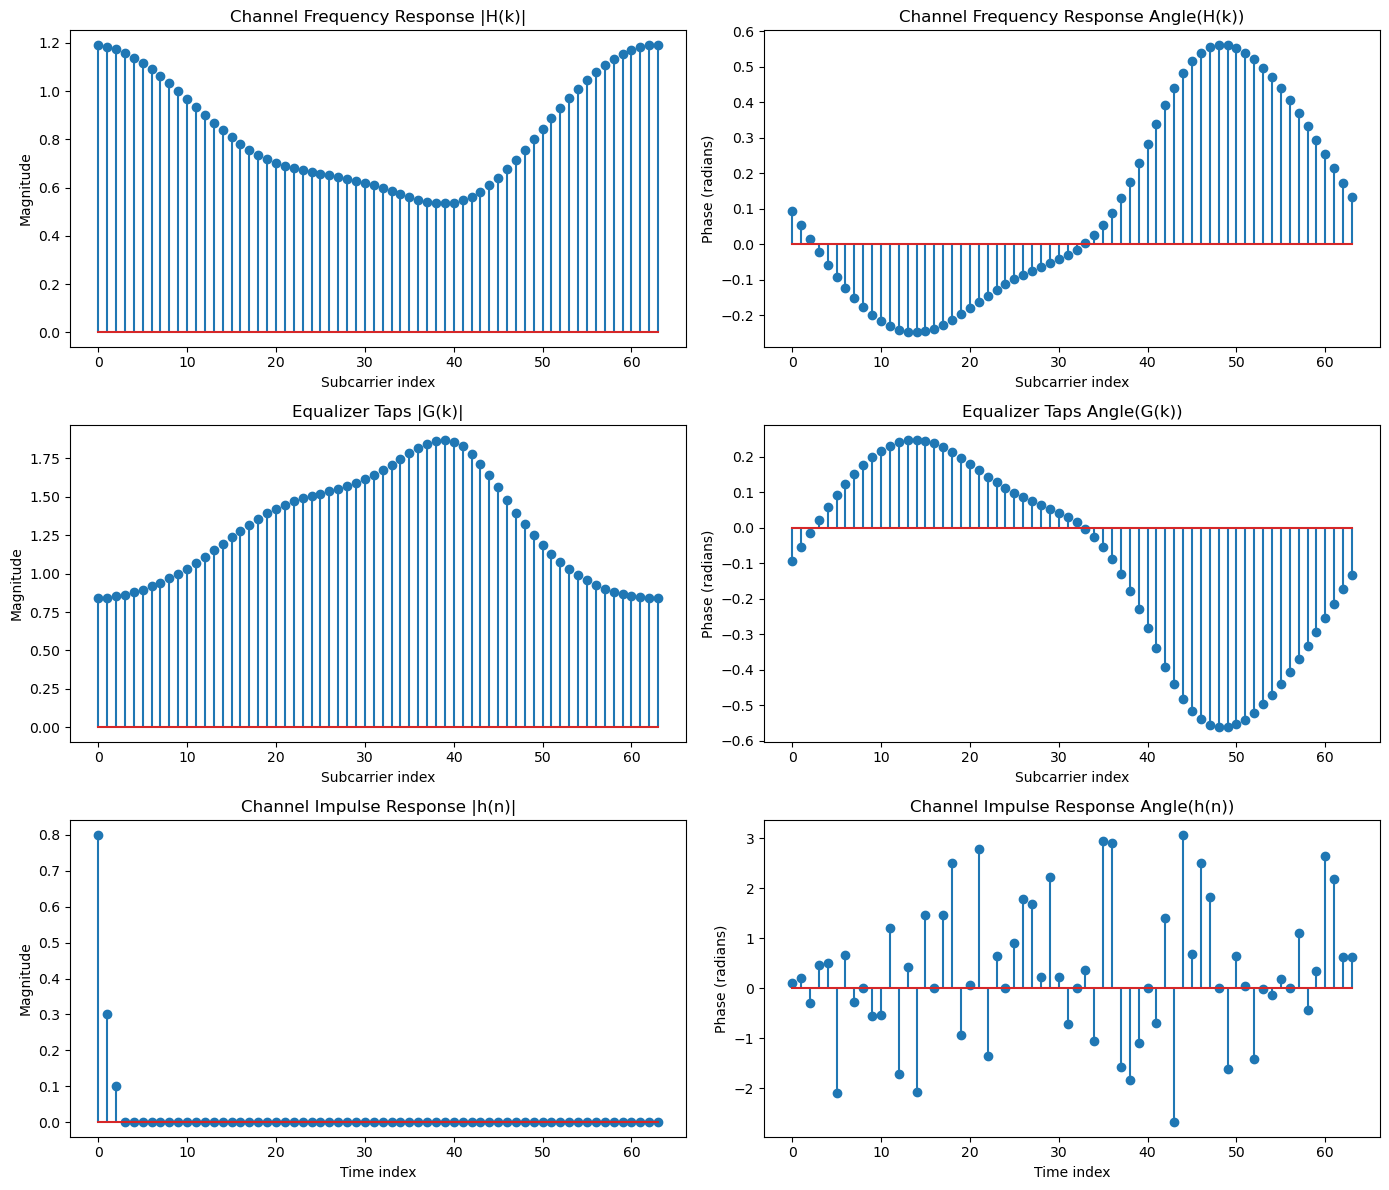

In [2]:
#!/usr/bin/env python3
import numpy as np
import matplotlib.pyplot as plt

def main():
    # Number of subcarriers (FFT size)
    N = 64

    # ----------------------------
    # 1. Define a simulated channel impulse response
    # Simulate a multipath channel with 3 taps:
    # Tap 0: delay 0, amplitude 0.8, phase 0.1 rad
    # Tap 1: delay 1, amplitude 0.3, phase 0.2 rad
    # Tap 2: delay 2, amplitude 0.1, phase -0.3 rad
    h = np.array([
        0.8 * np.exp(1j * 0.1),
        0.3 * np.exp(1j * 0.2),
        0.1 * np.exp(1j * -0.3)
    ], dtype=complex)

    # Zero-pad the impulse response to length N to obtain a full frequency response
    h_padded = np.zeros(N, dtype=complex)
    h_padded[:len(h)] = h

    # ----------------------------
    # 2. Compute the channel frequency response H(k)
    # This is computed by taking the FFT of the padded impulse response.
    H = np.fft.fft(h_padded)

    # ----------------------------
    # 3. Simulate a known sync (pilot) symbol
    # Assume the transmitted sync symbol X(k) is all ones.
    X = np.ones(N, dtype=complex)

    # The received sync symbol (Y) is affected by the channel:
    Y = H * X  # In an ideal (noise-free) situation, Y = H * X

    # ----------------------------
    # 4. Channel Estimation and Equalizer Taps
    # The estimated channel is:
    H_est = Y / X  # (Since X=1, H_est equals H exactly in this simulation)
    
    # Compute equalizer taps:
    # To undo the channel effects, we compute G(k) = 1 / H_est(k)
    G = 1.0 / H_est

    # ----------------------------
    # 5. Recover the Channel Impulse Response from H_est
    # This is done by taking the IFFT of H_est.
    h_est = np.fft.ifft(H_est)

    # ----------------------------
    # 6. Plot the results
    subcarrier_indices = np.arange(N)
    time_indices = np.arange(N)
    
    # Create a figure with multiple subplots (3 rows x 2 columns)
    fig, axs = plt.subplots(3, 2, figsize=(14, 12))
    
    # (A) Channel Frequency Response H(k)
    axs[0, 0].stem(subcarrier_indices, np.abs(H_est))
    axs[0, 0].set_title("Channel Frequency Response |H(k)|")
    axs[0, 0].set_xlabel("Subcarrier index")
    axs[0, 0].set_ylabel("Magnitude")
    
    axs[0, 1].stem(subcarrier_indices, np.angle(H_est))
    axs[0, 1].set_title("Channel Frequency Response Angle(H(k))")
    axs[0, 1].set_xlabel("Subcarrier index")
    axs[0, 1].set_ylabel("Phase (radians)")
    
    # (B) Equalizer Taps G(k) = 1/H_est(k)
    axs[1, 0].stem(subcarrier_indices, np.abs(G))
    axs[1, 0].set_title("Equalizer Taps |G(k)|")
    axs[1, 0].set_xlabel("Subcarrier index")
    axs[1, 0].set_ylabel("Magnitude")
    
    axs[1, 1].stem(subcarrier_indices, np.angle(G))
    axs[1, 1].set_title("Equalizer Taps Angle(G(k))")
    axs[1, 1].set_xlabel("Subcarrier index")
    axs[1, 1].set_ylabel("Phase (radians)")
    
    # (C) Channel Impulse Response (via IFFT of H_est)
    axs[2, 0].stem(time_indices, np.abs(h_est))
    axs[2, 0].set_title("Channel Impulse Response |h(n)|")
    axs[2, 0].set_xlabel("Time index")
    axs[2, 0].set_ylabel("Magnitude")
    
    axs[2, 1].stem(time_indices, np.angle(h_est))
    axs[2, 1].set_title("Channel Impulse Response Angle(h(n))")
    axs[2, 1].set_xlabel("Time index")
    axs[2, 1].set_ylabel("Phase (radians)")
    
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    main()


Subcarrier |   Pilot    |   H (Channel)           |   Y (Received)         |   G (Equalizer Tap = 1/H)
---------------------------------------------------------------------------------------------------------------
         0 | +1.000+0.000j | +0.647+0.470j            | +0.647+0.470j            | +1.011-0.735j           
         1 | +0.000+1.000j | +0.797+0.523j            | -0.523+0.797j            | +0.877-0.575j           
         2 | -1.000+0.000j | +0.978+0.465j            | -0.978-0.465j            | +0.834-0.397j           
         3 | -0.000-1.000j | +1.136+0.279j            | +0.279-1.136j            | +0.830-0.204j           
         4 | +1.000+0.000j | +1.200+0.000j            | +1.200+0.000j            | +0.833-0.000j           
         5 | +0.000+1.000j | +1.136-0.279j            | +0.279+1.136j            | +0.830+0.204j           
         6 | -1.000+0.000j | +0.978-0.465j            | -0.978+0.465j            | +0.834+0.397j           
         7 | -0.000-1.000j | 

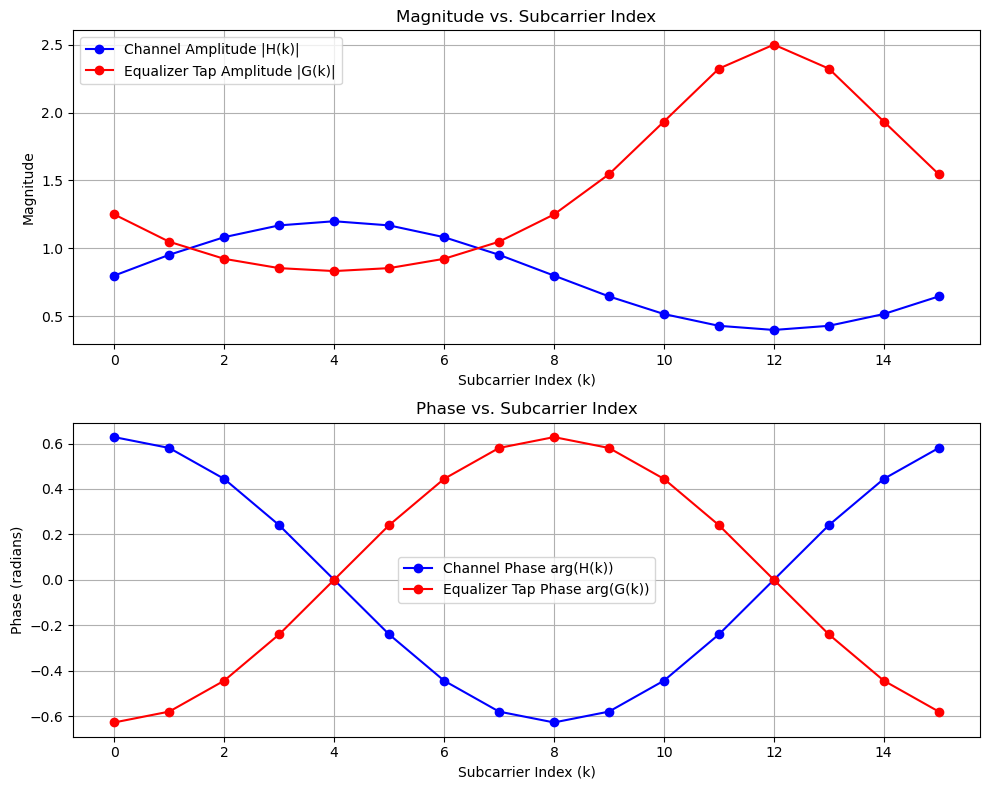

In [3]:
#!/usr/bin/env python3
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Parameters and OFDM settings
# -----------------------------
N = 16  # number of subcarriers (for illustration; typical systems use 64, 128, etc.)

# -----------------------------
# 1. Define a known pilot (synchronization) symbol in the frequency domain.
#    Here, we use a repeating QPSK pattern: 1, j, -1, -j.
#    In a real system, these pilots are known to both TX and RX.
# -----------------------------
pilot = np.array([1+0j, 1j, -1+0j, -1j] * (N // 4))

# -----------------------------
# 2. Define a channel H(k) that affects each subcarrier.
#    For each subcarrier k, we model H(k) as:
#      H(k) = amplitude(k) * exp(j * phase(k))
#
#    For example, let the amplitude vary sinusoidally and the phase vary cosinusoidally.
# -----------------------------
subcarrier_indices = np.arange(N)

# Amplitude varies between 0.8 and 1.2
amplitudes = 0.8 + 0.4 * np.sin(2 * np.pi * subcarrier_indices / N)

# Phase varies between -0.2π and 0.2π radians (approximately -0.63 to 0.63 rad)
phases = 0.2 * np.pi * np.cos(2 * np.pi * subcarrier_indices / N)

# Compute the complex channel response for each subcarrier:
H = amplitudes * np.exp(1j * phases)

# -----------------------------
# 3. Compute the received pilot Y(k) at the receiver.
#    In a noise-free simulation:
#      Y(k) = H(k) * X(k), where X(k) is the pilot.
# -----------------------------
Y = H * pilot

# -----------------------------
# 4. Estimate the channel using the known pilot.
#    Since we know X(k), we compute:
#      H_est(k) = Y(k) / X(k)
#
#    In our simulation (without noise), H_est should equal H exactly.
# -----------------------------
H_est = Y / pilot

# -----------------------------
# 5. Compute the equalizer taps G(k)
#    The goal is to remove the channel effects on data.
#    That is, for any future data symbol Y_d(k) = H(k) * X_d(k),
#    applying the equalizer tap G(k) should yield:
#      X_d(k) ≈ G(k) * Y_d(k) = X_d(k)
#
#    Therefore, the equalizer tap is:
#      G(k) = 1 / H_est(k)  (ideally, exactly the inverse of the channel)
# -----------------------------
G = 1 / H_est

# -----------------------------
# 6. Print out the math for each subcarrier.
# -----------------------------
print("Subcarrier |   Pilot    |   H (Channel)           |   Y (Received)         |   G (Equalizer Tap = 1/H)")
print("---------------------------------------------------------------------------------------------------------------")
for k in range(N):
    # Format complex numbers: use .3f for both real and imaginary parts.
    pilot_str = f"{pilot[k].real:+.3f}{pilot[k].imag:+.3f}j"
    H_str     = f"{H[k].real:+.3f}{H[k].imag:+.3f}j"
    Y_str     = f"{Y[k].real:+.3f}{Y[k].imag:+.3f}j"
    G_str     = f"{G[k].real:+.3f}{G[k].imag:+.3f}j"
    print(f"{k:10d} | {pilot_str:10s} | {H_str:24s} | {Y_str:24s} | {G_str:24s}")

# -----------------------------
# 7. Visualization:
#    Plot magnitude and phase of both the channel H and the equalizer taps G.
# -----------------------------
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Plot magnitude vs. subcarrier index
axs[0].plot(subcarrier_indices, np.abs(H), 'bo-', label="Channel Amplitude |H(k)|")
axs[0].plot(subcarrier_indices, np.abs(G), 'ro-', label="Equalizer Tap Amplitude |G(k)|")
axs[0].set_xlabel("Subcarrier Index (k)")
axs[0].set_ylabel("Magnitude")
axs[0].set_title("Magnitude vs. Subcarrier Index")
axs[0].legend()
axs[0].grid(True)

# Plot phase vs. subcarrier index
axs[1].plot(subcarrier_indices, np.angle(H), 'bo-', label="Channel Phase arg(H(k))")
axs[1].plot(subcarrier_indices, np.angle(G), 'ro-', label="Equalizer Tap Phase arg(G(k))")
axs[1].set_xlabel("Subcarrier Index (k)")
axs[1].set_ylabel("Phase (radians)")
axs[1].set_title("Phase vs. Subcarrier Index")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


Frequency-domain OFDM symbol (X):
Subcarrier  0: +0.000+0.000j
Subcarrier  1: +0.000+0.000j
Subcarrier  2: +1.000+1.000j
Subcarrier  3: -0.949+0.949j
Subcarrier  4: +0.949+0.949j
Subcarrier  5: +1.000+1.000j
Subcarrier  6: -0.316+0.949j
Subcarrier  7: -0.949+0.949j
Subcarrier  8: +1.000+1.000j
Subcarrier  9: +0.000+0.000j
Subcarrier 10: +0.000+0.000j
Subcarrier 11: +1.000+1.000j

Channel impulse response (h): [0.9+0.j  0.3+0.1j 0.1-0.1j]

Channel estimation on pilot subcarriers:
Pilot at subcarrier  2: H_est = +0.999-0.214j
Pilot at subcarrier  5: H_est = +0.844-0.177j
Pilot at subcarrier  8: H_est = +0.527+0.171j
Pilot at subcarrier 11: H_est = +1.227+0.287j

Data carriers:
Index    Transmitted         Received (after equalization)
 3      -0.949+0.949j          -0.902+0.920j
 4      +0.949+0.949j          +0.907+0.933j
 6      -0.316+0.949j          -0.134+1.007j
 7      -0.949+0.949j          -0.627+1.007j


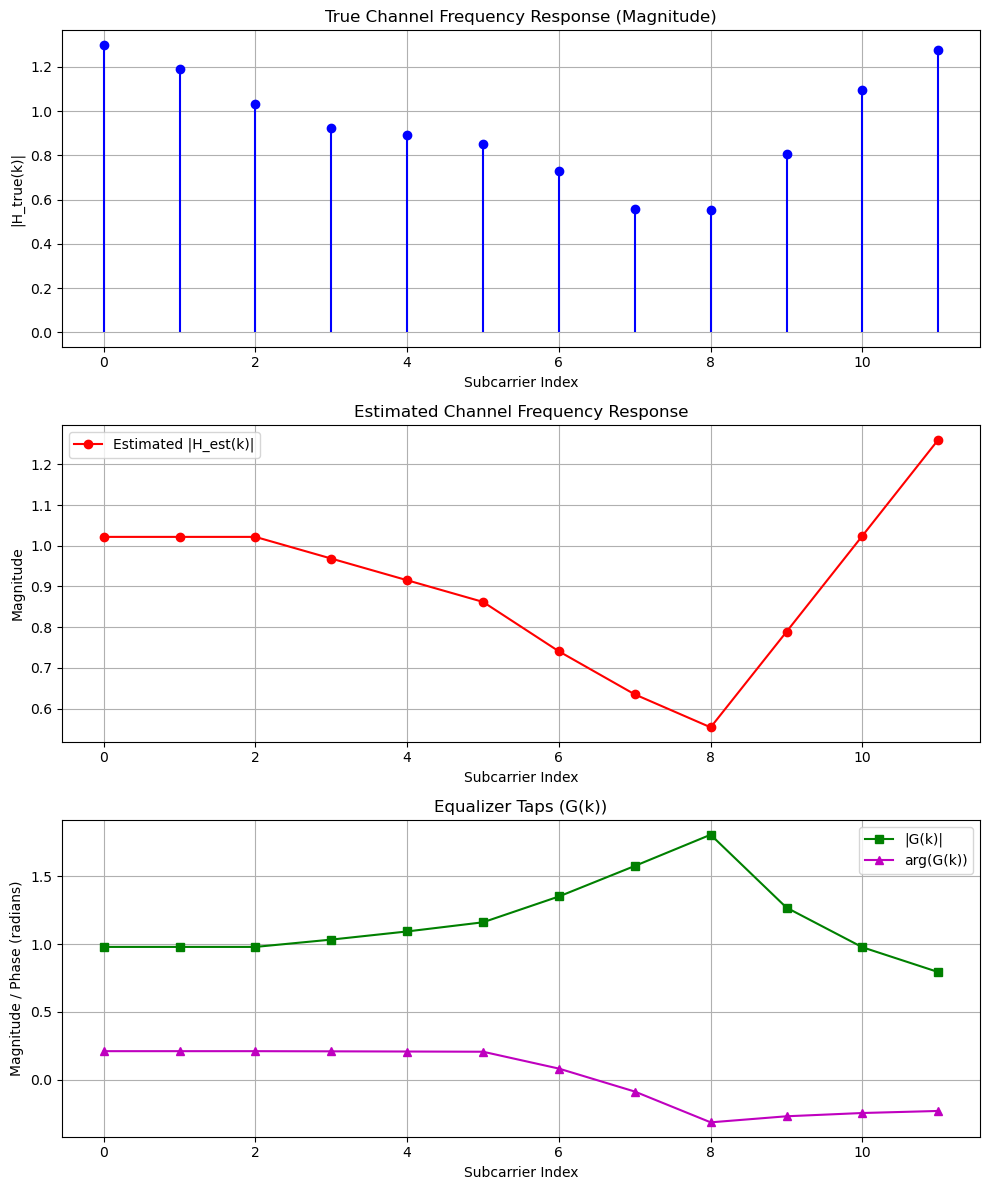

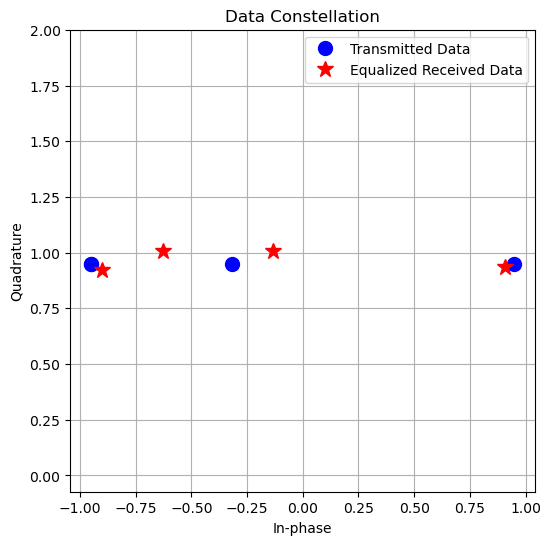

In [4]:
#!/usr/bin/env python3
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# 1. System Parameters
# -----------------------------
num_subcarriers = 12           # Total OFDM subcarriers
CP_length = 3                  # Cyclic prefix length
sample_rate = 120e3            # 120 kHz bandwidth (sample rate)
carrier_freq = 900e6           # 900 MHz (label only)
mod_order = 16                 # 16-QAM

# -----------------------------
# 2. Define Subcarrier Mapping
# -----------------------------
# We use 12 subcarriers. Among these, we designate:
#   - 4 pilot subcarriers (known symbols)
#   - 4 data subcarriers (carry 16-QAM data)
#   - 4 null subcarriers (guard bands)
#
# Here we choose (0-indexed indices):
#   Pilot indices: [2, 5, 8, 11]
#   Data indices:  [3, 4, 6, 7]
#   Null indices:  The rest: [0, 1, 9, 10]

pilot_indices = np.array([2, 5, 8, 11])
data_indices  = np.array([3, 4, 6, 7])
null_indices  = np.array([i for i in range(num_subcarriers) if i not in np.concatenate((pilot_indices, data_indices))])

# -----------------------------
# 3. Generate Frequency-Domain OFDM Symbol
# -----------------------------
# (a) Define pilot symbols. For simplicity, we use a constant pilot (e.g., 1+1j)
pilot_symbol = 1 + 1j
pilots = pilot_symbol * np.ones(len(pilot_indices), dtype=complex)

# (b) Generate random 16-QAM data symbols.
# For 16-QAM, the constellation points (before normalization) can be chosen from {-3, -1, 1, 3}.
# We will use these for both real and imaginary parts.
constellation_points = np.array([-3, -1, 1, 3])
# Randomly select one symbol per data subcarrier:
np.random.seed(0)  # for repeatability
data_symbols = (np.random.choice(constellation_points, len(data_indices)) +
                1j * np.random.choice(constellation_points, len(data_indices)))
# Optionally, normalize the constellation energy (average power 1)
norm_factor = np.sqrt((np.mean(np.abs(constellation_points)**2) * 2))  # roughly sqrt(10) for 16-QAM
data_symbols = data_symbols / norm_factor

# (c) Build the complete frequency-domain vector (length 12)
X = np.zeros(num_subcarriers, dtype=complex)
X[pilot_indices] = pilots
X[data_indices]  = data_symbols
# (The null subcarriers remain zero)

print("Frequency-domain OFDM symbol (X):")
for k in range(num_subcarriers):
    print(f"Subcarrier {k:2d}: {X[k]:+6.3f}")

# -----------------------------
# 4. OFDM Modulation: IFFT and CP addition
# -----------------------------
# Compute time-domain OFDM symbol (using IFFT)
# Here we assume the IFFT scaling factor is 1 (or equivalently, we include 1/N in the IFFT)
x = np.fft.ifft(X, n=num_subcarriers)

# Add cyclic prefix: take the last CP_length samples and prepend them
x_cp = np.concatenate((x[-CP_length:], x))

# -----------------------------
# 5. Channel: Simulate a Multipath Channel
# -----------------------------
# Define a simple multipath channel impulse response h.
# For example, a 3-tap channel:
h = np.array([0.9 + 0.0j, 0.3 + 0.1j, 0.1 - 0.1j])
print("\nChannel impulse response (h):", h)

# Convolve transmitted signal (with CP) with channel impulse response
y_channel = np.convolve(x_cp, h)  # length increases; we will extract the proper segment
# Optionally, add AWGN noise:
SNR_dB = 30  # high SNR for demonstration
signal_power = np.mean(np.abs(y_channel)**2)
noise_power = signal_power / (10**(SNR_dB/10))
noise = np.sqrt(noise_power/2) * (np.random.randn(len(y_channel)) + 1j*np.random.randn(len(y_channel)))
y_channel_noisy = y_channel + noise

# -----------------------------
# 6. Receiver: Remove CP and perform FFT
# -----------------------------
# The receiver knows the CP length. Extract the OFDM symbol:
y_rx = y_channel_noisy[CP_length:CP_length+num_subcarriers]

# FFT to recover frequency-domain received symbol:
Y = np.fft.fft(y_rx, n=num_subcarriers)

# -----------------------------
# 7. Channel Estimation from Pilots
# -----------------------------
# We assume that the receiver knows the transmitted pilot value.
# For each pilot subcarrier:
H_est_pilots = Y[pilot_indices] / pilots
print("\nChannel estimation on pilot subcarriers:")
for idx, k in enumerate(pilot_indices):
    print(f"Pilot at subcarrier {k:2d}: H_est = {H_est_pilots[idx]:+6.3f}")

# Interpolate the channel estimate to all subcarriers.
# For simplicity, we perform linear interpolation on the real and imaginary parts separately.
# (Assume pilots are sorted by index.)
pilot_pos = pilot_indices
H_est_real = np.interp(np.arange(num_subcarriers), pilot_pos, H_est_pilots.real)
H_est_imag = np.interp(np.arange(num_subcarriers), pilot_pos, H_est_pilots.imag)
H_est = H_est_real + 1j*H_est_imag

# -----------------------------
# 8. Compute Equalizer Taps (ofdm_sync_eq_taps)
# -----------------------------
# The equalizer tap on subcarrier k is:
#     G(k) = 1 / H_est(k)
G = 1 / H_est

# -----------------------------
# 9. Equalize Received Symbol and Extract Data
# -----------------------------
Y_eq = Y * G   # Apply equalizer on each subcarrier

# For data carriers, extract the equalized symbols:
data_received = Y_eq[data_indices]

# -----------------------------
# 10. Print Transmitted and Received Data Symbols
# -----------------------------
print("\nData carriers:")
print("Index    Transmitted         Received (after equalization)")
for i, k in enumerate(data_indices):
    print(f"{k:2d}      {data_symbols[i]:+6.3f}          {data_received[i]:+6.3f}")

# -----------------------------
# 11. Visualization
# -----------------------------
subcarrier_indices = np.arange(num_subcarriers)

# Plot estimated channel magnitude and phase vs. subcarrier index
fig, axs = plt.subplots(3, 1, figsize=(10, 12))

# (a) Plot the true channel frequency response
H_true = np.fft.fft(h, num_subcarriers)  # zero-padded FFT of the channel impulse response (for illustration)
axs[0].stem(subcarrier_indices, np.abs(H_true), linefmt='b-', markerfmt='bo', basefmt=" ")
axs[0].set_title("True Channel Frequency Response (Magnitude)")
axs[0].set_xlabel("Subcarrier Index")
axs[0].set_ylabel("|H_true(k)|")
axs[0].grid(True)

# (b) Plot the estimated channel vs. subcarrier index
axs[1].plot(subcarrier_indices, np.abs(H_est), 'ro-', label='Estimated |H_est(k)|')
axs[1].set_title("Estimated Channel Frequency Response")
axs[1].set_xlabel("Subcarrier Index")
axs[1].set_ylabel("Magnitude")
axs[1].legend()
axs[1].grid(True)

# (c) Plot the equalizer taps (ofdm_sync_eq_taps): magnitude and phase
axs[2].plot(subcarrier_indices, np.abs(G), 'gs-', label='|G(k)|')
axs[2].plot(subcarrier_indices, np.angle(G), 'm^-', label='arg(G(k))')
axs[2].set_title("Equalizer Taps (G(k))")
axs[2].set_xlabel("Subcarrier Index")
axs[2].set_ylabel("Magnitude / Phase (radians)")
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()

# (d) Additionally, plot constellation for data carriers (transmitted vs. equalized received)
plt.figure(figsize=(6,6))
plt.plot(data_symbols.real, data_symbols.imag, 'bo', markersize=10, label='Transmitted Data')
plt.plot(data_received.real, data_received.imag, 'r*', markersize=12, label='Equalized Received Data')
plt.title("Data Constellation")
plt.xlabel("In-phase")
plt.ylabel("Quadrature")
plt.legend()
plt.grid(True)
plt.axis('equal')

plt.show()


Transmitted Frequency-Domain Pilot Symbol (X):
Subcarrier  0: +0.000+0.000j
Subcarrier  1: +1.000+1.000j
Subcarrier  2: +0.000+0.000j
Subcarrier  3: +0.000+0.000j
Subcarrier  4: +1.000+1.000j
Subcarrier  5: +0.000+0.000j
Subcarrier  6: +0.000+0.000j
Subcarrier  7: +1.000+1.000j
Subcarrier  8: +0.000+0.000j
Subcarrier  9: +0.000+0.000j
Subcarrier 10: +1.000+1.000j
Subcarrier 11: +0.000+0.000j

Channel estimation on pilot subcarriers:
Pilot at subcarrier  1: H_est = +1.223-0.113j
Pilot at subcarrier  4: H_est = +0.964-0.220j
Pilot at subcarrier  7: H_est = +0.502-0.163j
Pilot at subcarrier 10: H_est = +0.912+0.499j

True channel impulse response h_true:
[0.9+0.j  0.3+0.2j 0.1-0.1j]
Estimated channel impulse response h_est (first 3 taps):
[0.90027129+0.00080228j 0.25734333+0.16967911j 0.06397803-0.04635746j]


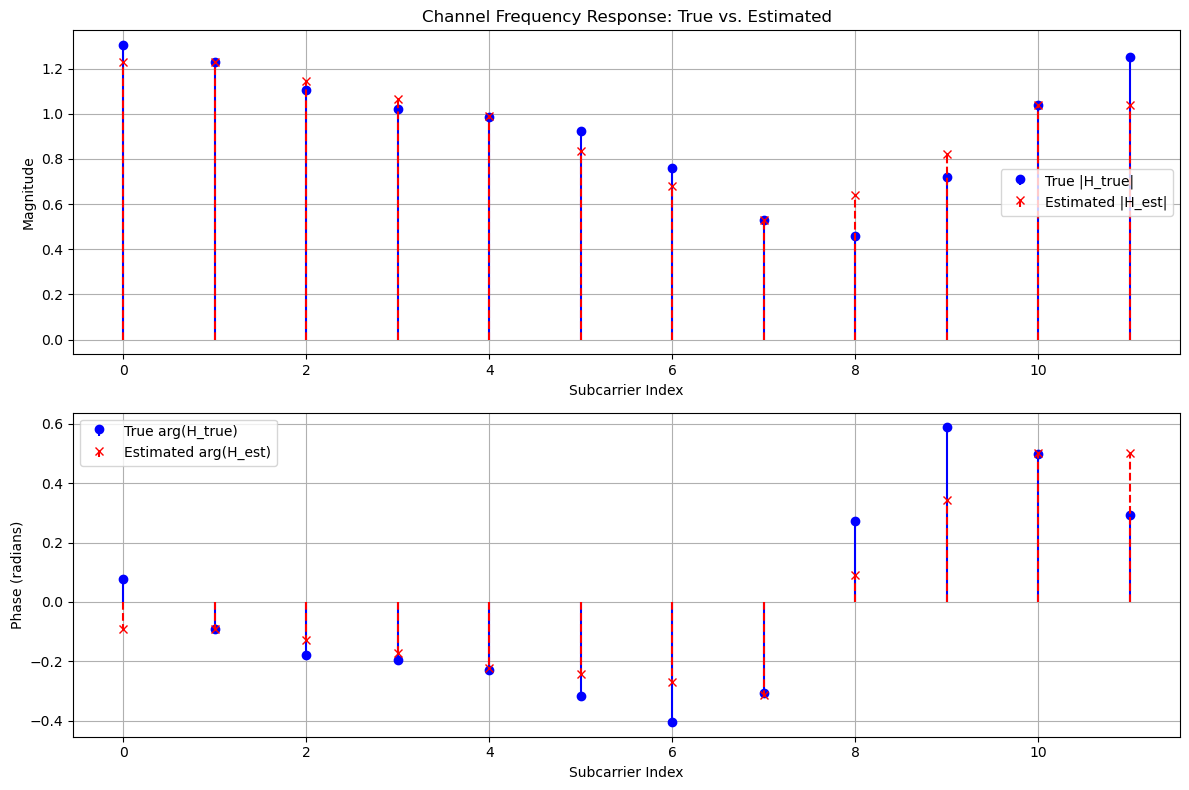

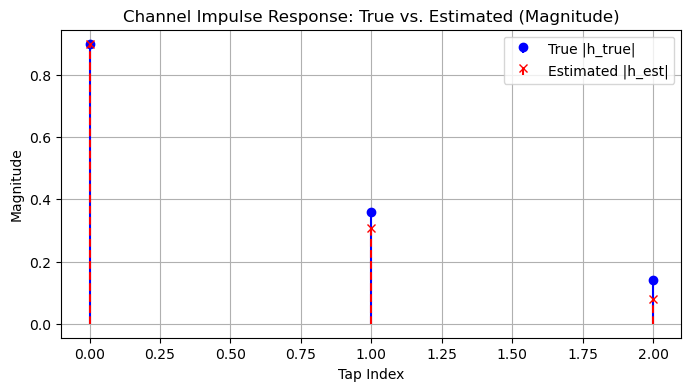

In [5]:
#!/usr/bin/env python3
import numpy as np
import matplotlib.pyplot as plt

# ============================================================================
# 1. System and OFDM Parameters
# ============================================================================
num_subcarriers = 12       # Total number of OFDM subcarriers
CP_length = 3              # Cyclic prefix length
sample_rate = 120e3        # 120 kHz bandwidth
carrier_freq = 900e6       # 900 MHz (label only)

# ============================================================================
# 2. Define the (unknown) channel impulse response h
#    In a real scenario, h is unknown and must be estimated.
#    Here, we simulate a multipath channel with 3 taps.
# ============================================================================
h_true = np.array([0.9 + 0j, 0.3 + 0.2j, 0.1 - 0.1j])
channel_length = len(h_true)

# For simulation, we can compute the channel frequency response on the OFDM grid:
H_true = np.fft.fft(h_true, n=num_subcarriers)

# ============================================================================
# 3. Create an OFDM pilot symbol for channel estimation
#
#    We use a pilot pattern with known values only on selected subcarriers.
#    Here, we choose pilot indices 1, 4, 7, and 10 (0-indexed).
# ============================================================================
pilot_indices = np.array([1, 4, 7, 10])
pilot_value = 1 + 1j  # Use a constant pilot value for simplicity

# Build the frequency-domain OFDM symbol.
# For pilot-based channel estimation, we set pilots at pilot_indices;
# non-pilot subcarriers are set to zero (i.e. not used for estimation).
X = np.zeros(num_subcarriers, dtype=complex)
X[pilot_indices] = pilot_value

print("Transmitted Frequency-Domain Pilot Symbol (X):")
for k in range(num_subcarriers):
    print(f"Subcarrier {k:2d}: {X[k]:+6.3f}")

# ============================================================================
# 4. OFDM Modulation: IFFT and CP Addition
# ============================================================================
# Convert the frequency-domain symbol to the time domain:
x = np.fft.ifft(X, n=num_subcarriers)
# Prepend the cyclic prefix (last CP_length samples)
x_cp = np.concatenate((x[-CP_length:], x))

# ============================================================================
# 5. Transmit the OFDM Symbol over the Channel
#
#    The transmitted signal passes through the unknown multipath channel.
#    We simulate this by convolving the time-domain signal with h_true.
# ============================================================================
y_channel = np.convolve(x_cp, h_true)

# Optionally, add some AWGN noise (here SNR = 40 dB for a high-SNR scenario)
SNR_dB = 40
signal_power = np.mean(np.abs(y_channel)**2)
noise_power = signal_power / (10**(SNR_dB/10))
noise = np.sqrt(noise_power/2) * (np.random.randn(len(y_channel)) + 1j * np.random.randn(len(y_channel)))
y_received = y_channel + noise

# ============================================================================
# 6. Receiver Processing: Remove CP and FFT
# ============================================================================
# Remove CP from the received signal
y_rx = y_received[CP_length:CP_length+num_subcarriers]
# Convert back to the frequency domain:
Y = np.fft.fft(y_rx, n=num_subcarriers)

# ============================================================================
# 7. Channel Estimation using Pilots
#
#    On the pilot subcarriers, the channel frequency response is estimated as:
#        H_est(k) = Y(k) / X(k)
# ============================================================================
H_est_pilots = Y[pilot_indices] / pilot_value

print("\nChannel estimation on pilot subcarriers:")
for idx, k in enumerate(pilot_indices):
    print(f"Pilot at subcarrier {k:2d}: H_est = {H_est_pilots[idx]:+6.3f}")

# Next, interpolate the channel estimate to all subcarriers.
# We perform linear interpolation on the real and imaginary parts separately.
all_indices = np.arange(num_subcarriers)
H_est_real = np.interp(all_indices, pilot_indices, H_est_pilots.real)
H_est_imag = np.interp(all_indices, pilot_indices, H_est_pilots.imag)
H_est = H_est_real + 1j * H_est_imag

# ============================================================================
# 8. Estimate the Channel Impulse Response h_est
#
#    By taking the IFFT of the full frequency-domain estimate H_est,
#    we obtain an estimate of the channel impulse response.
# ============================================================================
h_est = np.fft.ifft(H_est, n=num_subcarriers)

# Since the true channel impulse response is of length 3, we compare only the first 3 taps.
print("\nTrue channel impulse response h_true:")
print(h_true)
print("Estimated channel impulse response h_est (first 3 taps):")
print(h_est[:channel_length])

# ============================================================================
# 9. Visualization
# ============================================================================
# Plot frequency-domain channel responses: true vs. estimated
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.stem(all_indices, np.abs(H_true), linefmt='b-', markerfmt='bo', basefmt=' ', label='True |H_true|')
plt.stem(all_indices, np.abs(H_est), linefmt='r--', markerfmt='rx', basefmt=' ', label='Estimated |H_est|')
plt.title('Channel Frequency Response: True vs. Estimated')
plt.xlabel('Subcarrier Index')
plt.ylabel('Magnitude')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.stem(all_indices, np.angle(H_true), linefmt='b-', markerfmt='bo', basefmt=' ', label='True arg(H_true)')
plt.stem(all_indices, np.angle(H_est), linefmt='r--', markerfmt='rx', basefmt=' ', label='Estimated arg(H_est)')
plt.xlabel('Subcarrier Index')
plt.ylabel('Phase (radians)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot time-domain channel impulse responses (magnitude) for the first few taps:
plt.figure(figsize=(8, 4))
plt.stem(np.arange(channel_length), np.abs(h_true), linefmt='b-', markerfmt='bo', basefmt=' ', label='True |h_true|')
plt.stem(np.arange(channel_length), np.abs(h_est[:channel_length]), linefmt='r--', markerfmt='rx', basefmt=' ', label='Estimated |h_est|')
plt.xlabel('Tap Index')
plt.ylabel('Magnitude')
plt.title('Channel Impulse Response: True vs. Estimated (Magnitude)')
plt.legend()
plt.grid(True)
plt.show()


Loaded 79999 channel-tap vectors, each length 64.

Average of all channel-tap vectors:
[ 0.0000000e+00+0.00000000e+00j  0.0000000e+00+0.00000000e+00j
  0.0000000e+00+0.00000000e+00j  0.0000000e+00+0.00000000e+00j
  0.0000000e+00+0.00000000e+00j  0.0000000e+00+0.00000000e+00j
  5.8042345e-04+5.81176195e-04j  9.1248081e-04-1.91383697e-05j
  6.9961150e-04-7.00703240e-04j  2.1734810e-05-1.08485296e-03j
 -8.2164764e-04-8.50397511e-04j -1.2334238e-03-1.83315733e-05j
 -9.4485254e-04+9.42495477e-04j -1.6297819e-05+1.43750047e-03j
  9.8170550e-04+1.05026830e-03j  1.5019659e-03-1.60003913e-06j
  1.0783223e-03-1.08005852e-03j -1.7343749e-05-1.48501655e-03j
 -1.0378256e-03-1.01608445e-03j -1.4251601e-03+5.10979553e-05j
 -9.6645218e-04+1.02136750e-03j  2.5650128e-05+1.41099899e-03j
  9.0826588e-04+1.00295921e-03j  1.3230623e-03+1.13175018e-04j
  1.0039127e-03-7.45178433e-04j  1.7739374e-04-1.18359935e-03j
 -6.3596945e-04-9.71597619e-04j -1.0588184e-03-2.49608740e-04j
 -9.7311224e-04+4.69855731e-04j

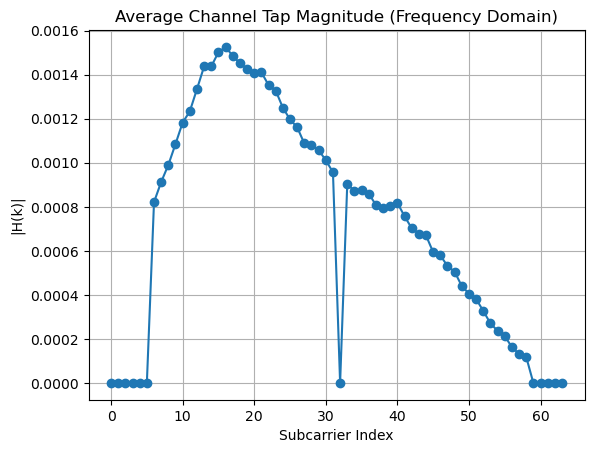

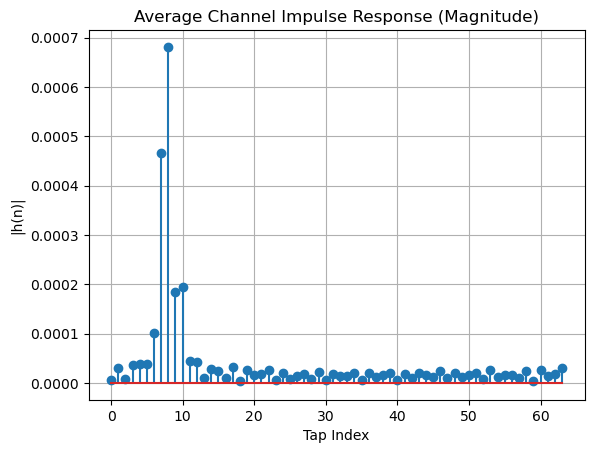

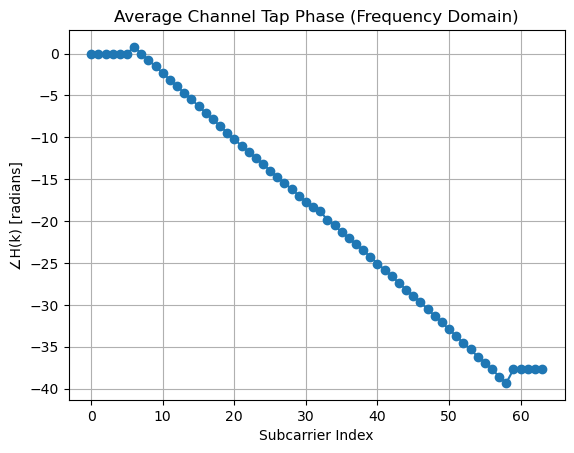

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Point to your channel taps file (Windows path)
file_path = r"C:\Users\mshif\chan_taps_10.dat"

# 1. Read the file as complex64 samples
data = np.fromfile(file_path, dtype=np.complex64)

# 2. Each OFDM channel estimate vector is length 64, so reshape accordingly
num_vectors = len(data) // 64
data = data.reshape(num_vectors, 64)

print(f"Loaded {num_vectors} channel-tap vectors, each length 64.")

# For demonstration, let’s take the first vector in the file.
#H_avg = data[0]
#print(H_avg)

# Compute the average across all vectors
H_avg = np.mean(data, axis=0)

# Print the average vector
print("\nAverage of all channel-tap vectors:")
print(H_avg)

# 3. Plot the frequency-domain magnitude of the average
plt.figure()
plt.plot(np.abs(H_avg), 'o-')
plt.title("Average Channel Tap Magnitude (Frequency Domain)")
plt.xlabel("Subcarrier Index")
plt.ylabel("|H(k)|")
plt.grid(True)
plt.show()

# 4. Convert average to time-domain impulse response via IFFT
h_avg = np.fft.ifft(H_avg)

# 5. Plot the magnitude of the average impulse response
plt.figure()
plt.stem(np.abs(h_avg))  # Removed use_line_collection=True for older matplotlib
plt.title("Average Channel Impulse Response (Magnitude)")
plt.xlabel("Tap Index")
plt.ylabel("|h(n)|")
plt.grid(True)
plt.show()

# Plot unwrapped phase of the average
plt.figure()
plt.plot(np.unwrap(np.angle(H_avg)), 'o-')
plt.title("Average Channel Tap Phase (Frequency Domain)")
plt.xlabel("Subcarrier Index")
plt.ylabel("∠H(k) [radians]")
plt.grid(True)
plt.show()

Mean delay  μτ = 8.95 µs   |   RMS delay spread στ = 6.50 µs


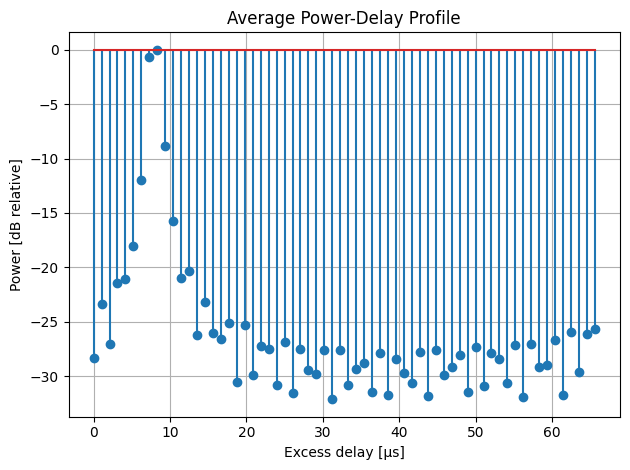

In [5]:
h = h_0;
h = np.fft.ifft(data, axis=1)                     # shape (N_sym, 64)
pdp = np.abs(h)**2                                # power, not amplitude

# 2) Average PDP over all symbols
pdp_avg = pdp.mean(axis=0)

# 3) Mean excess delay  (μ_τ)  and RMS delay spread  (σ_τ)
tap_times = np.arange(64) / (64 * 15e3)           # seconds, if Δf = 15 kHz
mean_τ = np.sum(pdp_avg * tap_times) / pdp_avg.sum()
rms_τ  = np.sqrt(np.sum(pdp_avg * (tap_times - mean_τ)**2) / pdp_avg.sum())
print(f"Mean delay  μτ = {mean_τ*1e6:.2f} µs   |   RMS delay spread στ = {rms_τ*1e6:.2f} µs")

# 4) Plot averaged PDP in dB
plt.figure()
plt.stem( tap_times*1e6, 10*np.log10(pdp_avg / pdp_avg.max()) )
plt.xlabel("Excess delay [µs]"); plt.ylabel("Power [dB relative]")
plt.title("Average Power-Delay Profile")
plt.grid(True); plt.tight_layout()

Loaded 47254 channel-tap vectors, each length 64.


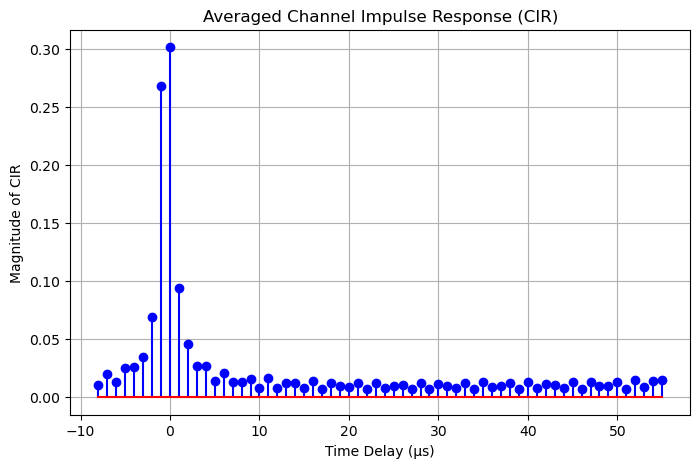

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Point to your channel taps file (Windows path)
file_path = r"C:\Users\mshif\dat\chan_taps.dat"

# Read the file as complex64 samples
data = np.fromfile(file_path, dtype=np.complex64)

# Each OFDM channel estimate vector is length 64, so reshape accordingly
num_vectors = len(data) // 64
data = data.reshape(num_vectors, 64)

print(f"Loaded {num_vectors} channel-tap vectors, each length 64.")

# Convert all vectors to time-domain CIR using IFFT
cir_all = np.fft.ifft(data, axis=1)  # IFFT along each vector (row-wise)

# Compute the **average CIR over all vectors**
cir_avg = np.mean(np.abs(cir_all), axis=0)  # Averaging across all received vectors

# Define time axis in microseconds
ofdm_bw = 1e6  # 1 MHz bandwidth
tap_spacing = 1 / ofdm_bw  # Time resolution per tap
time_axis = np.arange(len(cir_avg)) * tap_spacing * 1e6  # Convert to microseconds

# Normalize time so that the strongest (LOS) component starts from 0 μs
los_index = np.argmax(cir_avg)  # Find strongest tap (LOS component)
time_axis = time_axis - time_axis[los_index]  # Shift time axis

# Plot the averaged CIR
plt.figure(figsize=(8, 5))
plt.stem(time_axis, cir_avg, markerfmt='o', linefmt='b-', basefmt='r-')
plt.title("Averaged Channel Impulse Response (CIR)")
plt.xlabel("Time Delay (μs)")
plt.ylabel("Magnitude of CIR")
plt.grid(True)
plt.show()



Loaded 23541 channel-tap vectors, each length 64.
Channel frequency response (H_0):
[ 0.        +0.j          0.        +0.j          0.        +0.j
  0.        +0.j          0.        +0.j          0.        +0.j
  1.8226478 -0.37307757j  0.86050785-1.5554549j  -0.60129666-1.9234447j
 -1.6613618 -0.779474j   -2.1902857 +0.57815707j -1.3223855 +1.683819j
  0.39495587+1.9265597j   1.8997817 +1.5470799j   2.310904  -0.372252j
  1.3676419 -1.3689339j  -0.03253126-2.355795j   -1.2077818 -1.6810192j
 -2.2204583 -0.29034603j -1.8858597 +1.3924408j  -0.29988706+2.1584861j
  1.2862182 +1.9124296j   2.373474  +0.5583723j   2.1059947 -1.232398j
  0.73854387-2.1131759j  -1.1477602 -2.3119392j  -2.1826816 -1.037169j
 -2.205333  +0.67574394j -1.3546101 +2.1768978j   0.39716345+2.3888607j
  2.2462955 +1.3386937j   2.4664283 -0.38111514j  0.        +0.j
 -0.10227883-2.5036411j  -1.7419653 -1.5545564j  -2.179529  -0.18233448j
 -1.7511417 +1.8867548j  -0.29411447+2.315897j    1.2336938 +1.9441526j
  2.

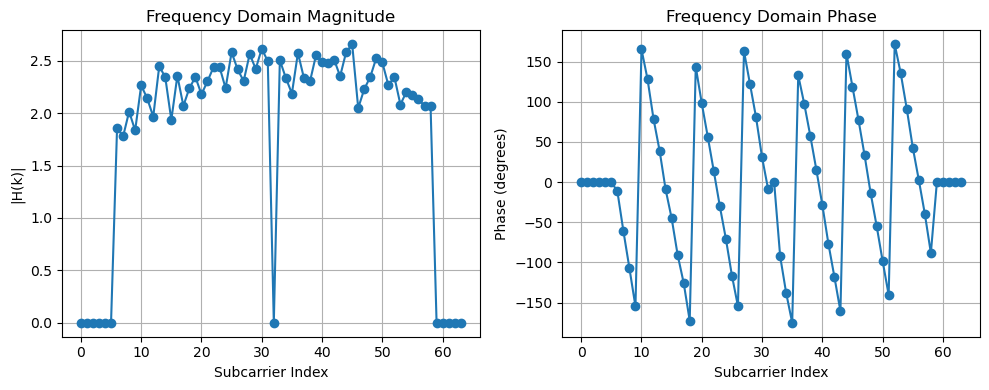

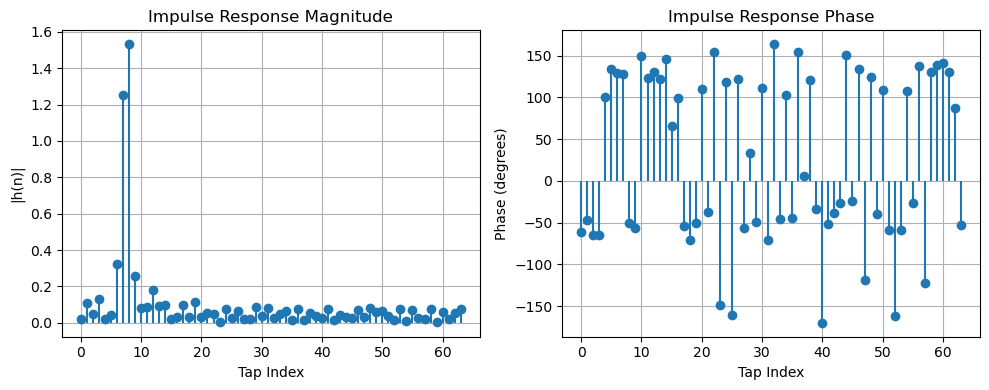

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Point to your channel taps file.
file_path = r"C:\Users\Minhaj\Files\chan_taps_21.dat"

# 1. Read the file as complex64 samples.
data = np.fromfile(file_path, dtype=np.complex64)

# 2. Each OFDM channel estimate vector is length 64, so reshape accordingly.
num_vectors = len(data) // 64
data = data.reshape(num_vectors, 64)

print(f"Loaded {num_vectors} channel-tap vectors, each length 64.")

# For demonstration, take the 101st vector (index 100).
H_0 = data[1000, :]
print("Channel frequency response (H_0):")
print(H_0)

# 3. Plot the frequency-domain magnitude and phase.
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(np.abs(H_0), 'o-')
plt.title("Frequency Domain Magnitude")
plt.xlabel("Subcarrier Index")
plt.ylabel("|H(k)|")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(np.angle(H_0, deg=True), 'o-')
plt.title("Frequency Domain Phase")
plt.xlabel("Subcarrier Index")
plt.ylabel("Phase (degrees)")
plt.grid(True)

plt.tight_layout()
plt.show()

# 4. Convert to time-domain impulse response via IFFT.
h_0 = np.fft.ifft(H_0)

# 5. Plot the time-domain (impulse response) magnitude and phase.
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.stem(np.abs(h_0), basefmt=" ")
plt.title("Impulse Response Magnitude")
plt.xlabel("Tap Index")
plt.ylabel("|h(n)|")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.stem(np.angle(h_0, deg=True), basefmt=" ")
plt.title("Impulse Response Phase")
plt.xlabel("Tap Index")
plt.ylabel("Phase (degrees)")
plt.grid(True)

plt.tight_layout()
plt.show()


Loaded 23541 channel-tap vectors, each length 64.


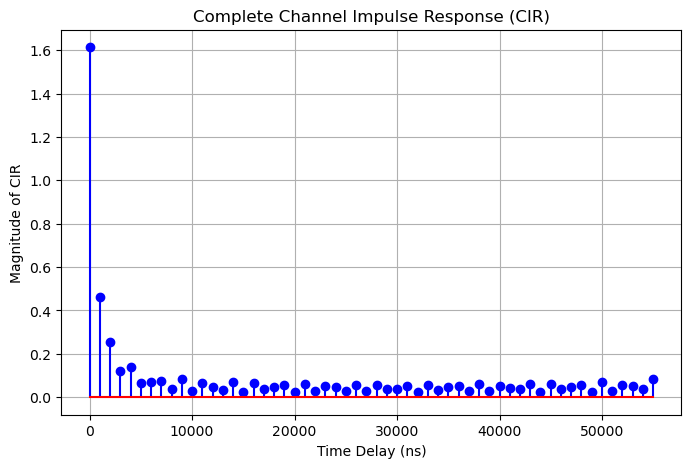

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Simulated: Path to channel taps file (Replace with actual file path)
file_path = r"C:\Users\Minhaj\chan_taps_21.dat"  # Change to your actual file path

# Read the file as complex64 samples
data = np.fromfile(file_path, dtype=np.complex64)

# Each OFDM channel estimate vector is length 64, so reshape accordingly
num_vectors = len(data) // 64
data = data.reshape(num_vectors, 64)

print(f"Loaded {num_vectors} channel-tap vectors, each length 64.")

# Convert all vectors to time-domain CIR using IFFT
cir_all = np.fft.ifft(data, axis=1)  # IFFT along each vector (row-wise)

# Compute the **average CIR over all vectors**
cir_avg = np.mean(np.abs(cir_all), axis=0)  # Averaging across all received vectors

# Define time axis in nanoseconds
ofdm_bw = 1e6  # 1 MHz bandwidth
tap_spacing = 1 / ofdm_bw  # Time resolution per tap (in seconds)
time_axis = np.arange(len(cir_avg)) * tap_spacing * 1e9  # Convert to nanoseconds

# Normalize time so that the strongest (LOS) component starts from 0 ns
los_index = np.argmax(cir_avg)  # Find strongest tap (LOS component)
time_axis = time_axis - time_axis[los_index]  # Shift time axis

# Select components within a larger window (entire CIR visualization)
time_limit_ns = max(time_axis)  # Ensure all taps are included
valid_indices = (time_axis >= 0) & (time_axis <= time_limit_ns)

# Extract CIR components within this range
time_selected = time_axis[valid_indices]
cir_selected = cir_avg[valid_indices]

# Plot the complete CIR
plt.figure(figsize=(8, 5))
plt.stem(time_selected, cir_selected, markerfmt='o', linefmt='b-', basefmt='r-')
plt.title("Complete Channel Impulse Response (CIR)")
plt.xlabel("Time Delay (ns)")
plt.ylabel("Magnitude of CIR")
plt.grid(True)
plt.show()


Processed 66686 channel vectors, 64 taps each


ValueError: zero-size array to reduction operation minimum which has no identity

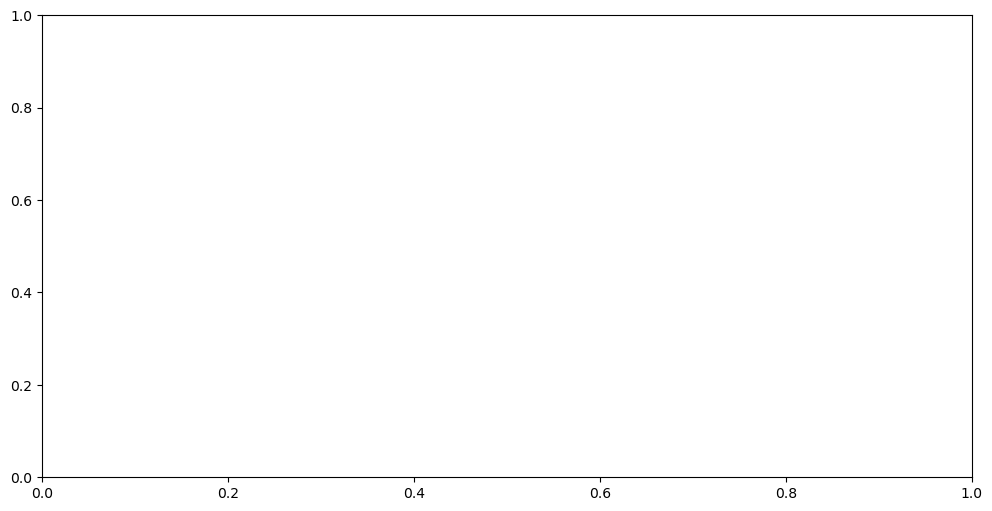

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Configuration
file_path = r"C:\Users\Minhaj\chan_taps.dat"  # Path to the channel taps file
ofdm_bandwidth = 1e6  # 1 MHz bandwidth
num_taps = 64  # Number of subcarriers/OFDM symbol
window_ns = 100  # Time window to analyze (in nanoseconds)

# Read and reshape data
data = np.fromfile(file_path, dtype=np.complex64)  # Read the binary file as complex64
num_vectors = len(data) // num_taps  # Number of OFDM symbols
channel_vectors = data[:num_vectors * num_taps].reshape(num_vectors, num_taps)  # Reshape into 2D array

print(f"Processed {num_vectors} channel vectors, {num_taps} taps each")

# Convert to time-domain CIR for all vectors
cir_time = np.fft.ifft(channel_vectors, axis=1)  # IFFT along subcarriers to get CIR

# Calculate time axis in nanoseconds
tap_spacing = 1 / ofdm_bandwidth  # Time resolution per tap in seconds
time_ns = np.arange(num_taps) * tap_spacing * 1e9  # Convert to nanoseconds

# Find the LOS component (strongest tap) and align it to time zero
avg_cir_mag = np.mean(np.abs(cir_time), axis=0)  # Average magnitude across all CIRs
los_tap_index = np.argmax(avg_cir_mag)  # Index of the LOS component
time_ns_aligned = time_ns - time_ns[los_tap_index]  # Shift time axis to align LOS at 0 ns

# Extract the 100 ns window
window_samples = int(window_ns / (tap_spacing * 1e9))  # Number of samples in 100 ns
start_index = max(los_tap_index - window_samples // 2, 0)  # Ensure start index is >= 0
end_index = min(los_tap_index + window_samples // 2, num_taps)  # Ensure end index is <= num_taps

# Average magnitude response across all CIRs in the 100 ns window
avg_cir_mag_window = np.mean(np.abs(cir_time[:, start_index:end_index]), axis=0)
time_ns_window = time_ns_aligned[start_index:end_index]

# Plot settings
plt.figure(figsize=(12, 6))
plt.stem(time_ns_window, avg_cir_mag_window, linefmt='b-', markerfmt='bo', basefmt='r-', label='CIR Magnitude')
plt.title(f"Averaged Channel Impulse Response (Aligned to LOS, {window_ns} ns window)\n"
          f"OFDM Bandwidth: {ofdm_bandwidth / 1e6} MHz, Time Resolution: {tap_spacing * 1e9:.1f} ns/tap")
plt.xlabel("Time Delay (ns)")
plt.ylabel("Average Magnitude")
plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.xlim(time_ns_window[0], time_ns_window[-1])

# Add second x-axis showing tap index
ax2 = plt.gca().twiny()
ax2.set_xlabel("Tap Index")
ax2.set_xticks(np.arange(start_index, end_index, 2))
ax2.set_xlim(plt.gca().get_xlim())

plt.legend()
plt.tight_layout()
plt.show()

In [2]:
import numpy as np

# Path to your channel taps file
file_path = r"C:\Users\Minhaj\Files\chan_taps_21.dat"

# Read the file as complex64 samples
data = np.fromfile(file_path, dtype=np.complex64)

# Each OFDM channel estimate vector is length 64, so reshape accordingly
num_vectors = len(data) // 64
data = data.reshape(num_vectors, 64)

print(f"Loaded {num_vectors} channel-tap vectors, each length 64.")

# Convert all vectors to time-domain CIR using IFFT
cir_all = np.fft.ifft(data, axis=1)  # IFFT along each vector (row-wise)

# Compute the **average CIR over all vectors**
cir_avg = np.mean(np.abs(cir_all), axis=0)  # Averaging across all received vectors

# Define time axis in nanoseconds
ofdm_bw = 1e6  # 1 MHz bandwidth
tap_spacing = 1 / ofdm_bw  # Time resolution per tap (in seconds)
time_axis = np.arange(len(cir_avg)) * tap_spacing * 1e9  # Convert to nanoseconds

# Compute Power Delay Profile (PDP)
pdp = cir_avg ** 2  # Power of each tap

# Compute Mean Delay (τ̄)
mean_delay = np.sum(time_axis * pdp) / np.sum(pdp)

# Compute RMS Delay Spread (τ_RMS)
rms_delay_spread = np.sqrt(np.sum(pdp * (time_axis - mean_delay) ** 2) / np.sum(pdp))

print(f"Mean Delay: {mean_delay:.2f} ns")
print(f"RMS Delay Spread: {rms_delay_spread:.2f} ns")



Loaded 23541 channel-tap vectors, each length 64.
Mean Delay: 8891.06 ns
RMS Delay Spread: 6172.14 ns
